## **Light Curves**

In the second week of PRA3024, we were asked to construct a light curve for 2 planets, based on two exercises (beginner_tess_exomast: Method 1 and interm_tesscut_astroquery: Method 2). A light curve is a measure of how much the flux of an object (star) changes in a certain period of time. This can be due to: planet orbiting a star, a variable star, a binary star system, a supernova explosion... The data was obtained from TESS mission (Transiting Exoplanet Survey Sattelite). In addition to solving the two exercises mentioned above for the 2 systems of choice, I have also included a calculation of the radius of the orbit of a planet for the first method, an animation for the second method, and added an example of a light curve of a supernova explosion. The code for the supernova explosion was found online, while the calculation of radius in 2 different ways is entirely original and important for understanding of the physics. Throughout the code, I have been slightly modifying parts of the code which I otherwise found elsewhere online, with the aim of making it better fit my data/look nicer.

# Light Curve & Planet Parameters (Method 1)




Import statements, necessary for the program to run: 

Aside from import statements, 2 base URLs used for future requests are specified (planet url-used to query plant table; data validation url-query data validation database (header, light curves))

In [5]:
############### INSTALLATIONS ######################
!pip install astroquery
!pip install lightkurve
############### IMPORTS ############################
import numpy as np
import requests
from IPython.display import display, HTML
import pandas as p
from astroquery.mast import Catalogs
from astroquery.mast import Tesscut
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.io import fits
# For querying for data
import requests
from astroquery.mast import Tesscut
# For manipulating data
from astropy.table import Table
import re
# For matplotlib plotting
import matplotlib
import matplotlib.pyplot as plt  
import matplotlib.animation as animation
# For animation display
from matplotlib import rc
from IPython.display import HTML
rc('animation', html='jshtml')
# For bokeh plotting
from bokeh import plotting
# sys so I can throw all those nice errors that are bound to happen
import sys
plotting.output_notebook()
from lightkurve import search_targetpixelfile
%matplotlib inline


planeturl = "https://exo.mast.stsci.edu/api/v0.1/exoplanets/"
dvurl = "https://exo.mast.stsci.edu/api/v0.1/dvdata/tess/"
header={}

The cell below gives the known identifiers for our planet. It takes the name of the planet as an input, and gives a json file as an output (this can be converted to a Python dictionary).

In [6]:
planet_name = "WASP-100 b"

url = planeturl + "/identifiers/"

myparams = {"name":planet_name}

r = requests.get(url = url, params = myparams, headers = header)
print(r.headers.get('content-type'))

application/json; charset=UTF-8


The dictionary mentioned above contains all the names associated with the planet of choice. Here below I access these names and save tessID (tess-transiting exoplanet survey sattelite) and tessTCE (TCE-threshold crossing event="periodic signals exceeding nominal signal-to-noise requirement") as variables used later on. It is imporant that these two fields exist, as otherwise there would not exist a TCE on TIC ID (ID of the object of interest) with the same period, meaning that we would have a difficult job generating plots and acquiring data!

In [7]:
planet_names = r.json()
ticid = planet_names['tessID']
tce = planet_names['tessTCE']
planet_names

{'canonicalName': 'WASP-100 b',
 'dec': -64.02702777756585,
 'keplerID': None,
 'keplerTCE': None,
 'planetNames': ['GSC 08884-00719 b',
  'PPM 354220 b',
  'Gaia DR1 4675352105362405504 b',
  '1SWASP J043550.32-640137.3 b',
  '2MASS 04355033-6401373 b',
  'CPD-64 356 b',
  'WASP-100 b',
  'TYC 8884-719-1 b',
  '2MASS J04355033-6401373 b'],
 'ra': 68.9596666653951,
 'starName': 'WASP-100',
 'tessID': 38846515,
 'tessTCE': 'TCE_1'}

**Planet Properties**

Now some of the planet's properties will be extracted. This code can access 2 exoplanet tables, from: NExScl (NASA Exoplanet Science Institute) and Exoplanets.org. In case we are lucky enough we can get a planet that is listed in both tables, and later we can access data (planet mass etc) from both sources. In that case, the 0th element contains Exoplanets.org and the 1st element contains NExScI properties. The information from different sources is not necessarily exactly the same, but small decimal places errors are expected (it is very difficult to obtain precise data in astronomy, as we are usually dealing with objects very far away from us,leading to greater errors... Having computed some of the basic properties ourselves in astonomy classes makes me impressed how close the numbers for the same phenomena from different sources are!).

In [8]:
url = planeturl + planet_name + "/properties/"

r = requests.get(url = url, headers = header)

planet_prop = r.json()

print("Catalog 1: " + planet_prop[0]['catalog_name'])
print("Catalog 2: " + planet_prop[1]['catalog_name'])
planet_prop[0].keys()

Catalog 1: exoplanets.org
Catalog 2: nexsci


dict_keys(['canonical_name', 'exoplanetID', 'catalog_name', 'planet_name', 'disposition', 'modified_date', 'star_name', 'component', 'Rs', 'Rs_unit', 'Rs_upper', 'Rs_lower', 'Rs_ref', 'Rs_url', 'Ms', 'Ms_unit', 'Ms_upper', 'Ms_lower', 'Ms_ref', 'Ms_url', 'Fe/H', 'Fe/H_upper', 'Fe/H_lower', 'Fe/H_ref', 'Fe/H_url', 'stellar_gravity', 'stellar_gravity_upper', 'stellar_gravity_lower', 'stellar_gravity_ref', 'stellar_gravity_url', 'Teff', 'Teff_unit', 'Teff_upper', 'Teff_lower', 'Teff_ref', 'Teff_url', 'Vmag', 'Vmag_unit', 'Vmag_upper', 'Vmag_lower', 'Vmag_ref', 'Vmag_url', 'Jmag', 'Jmag_unit', 'Jmag_upper', 'Jmag_lower', 'Jmag_ref', 'Jmag_url', 'Hmag', 'Hmag_unit', 'Hmag_upper', 'Hmag_lower', 'Hmag_ref', 'Hmag_url', 'Kmag', 'Kmag_unit', 'Kmag_upper', 'Kmag_lower', 'Kmag_ref', 'Kmag_url', 'RA', 'DEC', 'distance', 'distance_unit', 'distance_upper', 'distance_lower', 'distance_ref', 'distance_url', 'Rp', 'Rp_unit', 'Rp_upper', 'Rp_lower', 'Rp_ref', 'Rp_url', 'Mp', 'Mp_unit', 'Mp_upper', 'Mp_l

It is indeed seen that the data exists in both, Exoplanets.org and NExScI tables. For convenience, some basic properties of our system acquired from both sources are printed below.

In [9]:
print("WASP-18 b Properties from Exoplanets.org")
print("Stellar Mass %f %s" % (planet_prop[0]['Ms'], planet_prop[0]['Ms_unit'] ) )
print("Planet Mass %f %s" % (planet_prop[0]['Mp'], planet_prop[0]['Mp_unit'] ) )
print("Planet Mass Reference: %s" % (planet_prop[0]['Mp_ref']))
print("""
""")
print("WASP-18 b Properties from NExScI")
print("Stellar Mass %f %s" % (planet_prop[1]['Ms'], planet_prop[1]['Ms_unit'] ) )
print("Planet Mass %f %s" % (planet_prop[1]['Mp'], planet_prop[1]['Mp_unit'] ) )
print("Planet Mass Reference: %s" % (planet_prop[1]['Mp_ref']))

WASP-18 b Properties from Exoplanets.org
Stellar Mass 1.570000 M_sun
Planet Mass 2.030000 M_Jupiter
Planet Mass Reference: Hellier 2013


WASP-18 b Properties from NExScI
Stellar Mass 0.770000 M_sun
Planet Mass 1.260000 M_Jupiter
Planet Mass Reference: Stassun et al. 2017


Observations:

It can clearly be seen that in this system, the mass of the star as well as the mass of the planet differ greatly based on the source of the information (as predicted). The values of the data from Exoplanets.org are more than twice bigger than the data from NExScI. This issue will be tackled lateron, when I will use some of these values to compute the radius of the orbit of the planet.

**Accesing TCE Data for our planet**

Firstly, the header and the data accosiated with the Threshold Crossing Event that corresponds to the trajectory of the planet are retrieved. Secondly, the sector ranges for our query are defined. Since TESS mission covers multiple areas of the sky (=sectors) and does multi-sector searches, and since some stars are observed in more than 1 sector, the sector in which a TCE occurs on our star must be defined. Then the sector ranges for query are defined. 

In [10]:
url = dvurl + str(ticid) + '/tces/'
myparams = {"tce" : tce}

r = requests.get(url = url, params = myparams, headers = header)
sectorInfo = r.json()

sectors = [x[:11] for x in sectorInfo["TCE"] if tce in x]
sectors

['s0005-s0005',
 's0001-s0003',
 's0002-s0002',
 's0013-s0013',
 's0008-s0008',
 's0001-s0001',
 's0012-s0012',
 's0011-s0011',
 's0001-s0006',
 's0003-s0003',
 's0001-s0009',
 's0006-s0006',
 's0009-s0009',
 's0010-s0010',
 's0001-s0002',
 's0007-s0007',
 's0004-s0004',
 's0001-s0013']

In [11]:
url = dvurl + str(ticid) + '/info/'
myparams = {"tce" : tce,
            "sector" : sectors[0]}

r = requests.get(url = url, params = myparams, headers = header)
tceInfo = r.json()
tceInfo.keys()
tceInfo['DV Data Header'].keys()

print("TIC: %s" % tceInfo['DV Primary Header']['OBJECT'])
print("Planet Radius: %f" % tceInfo['DV Data Header']['PRADIUS'])

TIC: TIC 38846515
Planet Radius: 9.026679


**Plotting the Light Curve**

There are different kinds of light curves. For example:

LC_DETREND = the median detrended light curve.

LC_INIT = the initial light curve used to search for the TCE.

MODEL_INIT = a light curve of the transit model

We will make use of some of them.

Firstly, to get the data:

In [0]:
url = dvurl + str(ticid) + '/table/'
myparams = {"tce" : tce,
            "sector" : sectors[0]}

r = requests.get(url = url, params = myparams, headers = header)
tce_data = r.json()

In [13]:
data = p.DataFrame.from_dict(tce_data['data'])
data.columns

Index(['TICID', 'EXTNAME', 'TIME', 'TIMECORR', 'CADENCENO', 'PHASE', 'LC_INIT',
       'LC_INIT_ERR', 'LC_WHITE', 'LC_DETREND', 'MODEL_INIT', 'MODEL_WHITE',
       'DATE_OBS', 'TESSDatetime', 'SECTORS'],
      dtype='object')

Plot a light curve of a transit model:

Firstly, just the relative flux for a large time period is plotted and then a specific range of x axis (time) is chosen that just corresponds to 1 orbital period, which will be needed later on.

orbital period is 2.8599999999999 days, so approximately 2.85 days.


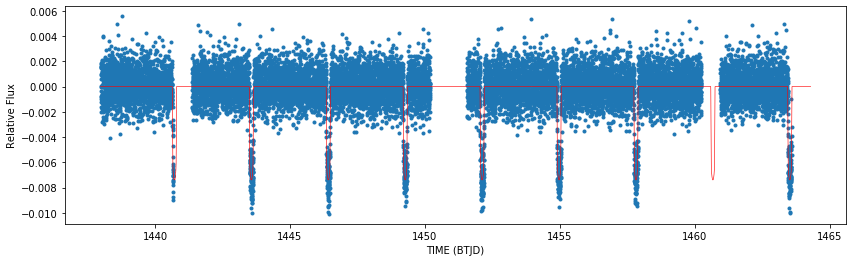

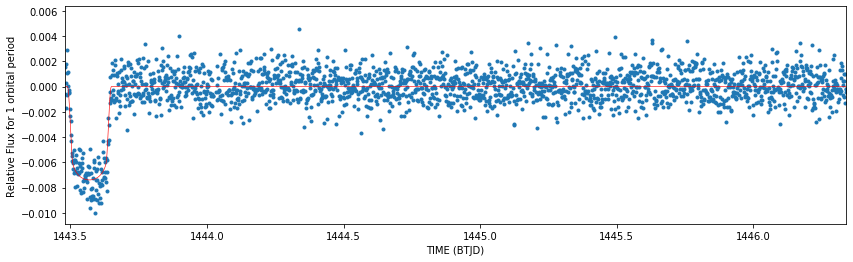

In [14]:
detrend = data['LC_DETREND']
model = data['MODEL_INIT']
time = data['TIME']
#print(data['TIME'])


plt.figure(figsize=(14,4))
plt.plot(time,detrend,'.',lw=0.4)
plt.plot(time,model,'r-',lw=0.6)
plt.xlabel('TIME (BTJD)')
plt.ylabel('Relative Flux')


plt.figure(figsize=(14,4))
plt.xlim(1443.48,1446.34)
plt.plot(time,detrend,'.',lw=0.4)
plt.plot(time,model,'r-',lw=0.6)
plt.xlabel('TIME (BTJD)')
plt.ylabel('Relative Flux for 1 orbital period')
print("orbital period is", 1446.34 - 1443.48, "days, so approximately 2.85 days.")

From the graph it is obvious that the relative flux periodically decrases (all the dips). There are many periodic events plotted on top of each other. Blank sections mean that there exists no data for a given time period (though the flux value is still predicted, based on the existing data points).

Since the dips are approximately equally deep (with some random, non-periodic deviations), we may, solely on the base of this graph, conclude that the TCE is not due to for example eclypsing binary star system, but more likely due to planet transit for instance.


**Bokeh Phased Light Curve**

The following piece of code zooms into 1 phase of the light curve. All, detrended, folded and binned light curves are presented, with the transit model drawn on top of the graph (which corresponds to a planet transit). The graph can be zoomed into and examined.

In [0]:
url = dvurl + str(ticid) + '/phaseplot/'
myparams = {"tce" : tce,
            "sector" : sectors[0]}

r = requests.get(url = url, params = myparams, headers = header)

In [17]:
display(HTML(str(r.content.decode('utf-8'))))

**Discussion of Results**


A nice, U-shaped curve is observed. One might wonder why the bottom of the graph is not flat, but curved (once the planet is fully in front of the star, the flux should not vary anymore... or should it?). 
The bottom of the graph is curved due to the phenomena called "limb darkening". This occurs because the flux of the star as perceived by us is not homogeneous; the middle part of the star appears more luminous than the side parts. That is because one can only see a certain distance in the star (denoted by L on the graph below), which corresponds to a certain temperature on the innermost part (T determines luminosity). Looking straight to the middle of the star allows to see "the deepest" into the star (point A), where the higest T and highest energy photons are, resulting in the greatest luminosity. The opposite happens on the side of the star (B), as illustrated in the figure below. The figure was taken from Wikipedia.

![An idealized case of limb darkening. The outer boundary is the radius at which photons emitted from the star are no longer absorbed. L is a distance for which the optical depth is unity. High-temperature photons emitted at A will just barely escape from the star, as will the low-temperature photons emitted at B.](https://upload.wikimedia.org/wikipedia/commons/d/d4/Limb_darkening_layers.svg)

Taking limb darkening into account, we can even obtain (though very limited) information about the plane of the planet orbiting the star. If no limb darkening was present, that means that the orbit of the planet would be highly tilted with respect to us (the planet would be at all times passing just at the boundary of the star). From the curve above we can conclude that our planet passes at least close to the center of the star, as seen by us. Otherwise no limb darkening would be observed. Hovever, the planes of the orbits of planets can also change, so we are very limited in that regard. 

**THE UNDRLYING PHYSICS: Calculation of radius of the planet orbiting the star - original work**

Orbital period was read off the graph for Relative flux for 1 orbital period (additional graph, made solely for this part of the task by me). It was measured to be 2.85 days, which is in agreement with Exo.mast measurements. Mass of the star was obtained in the "planet properties" section. Based on these 2 info, it should be possible to deduce the radius of the orbit.


First attempt: Using General Relativity to calculate the radius of the orbit


In GR, motion of objects is described by geodesic equation. This was here solved for circular motion, since eccentricity of our planet is 0. It was assumed that the star was spherically symmetrical, non-rotating object (=schwarzschid spacetime metric). Experienced physicst should be able to solve the equation in 1 hour (while unexperienced student took plenty of hours to do so-what a motivation!). The solutions for circular motion were found to be:


In [0]:
# t(tau) = sqrt((1-3MG/Rc^2)^(-1)) tau
# r(tau)=R
# theta(tau)=pi/2
# phi(tau) = sqrt(MG/R^3 * (1-3MG/Rc^2)^(-1)) tau

Using these equations and the fact that the full circle should be completed in 2.85 days, it is straightforward to construct the equation for the radius of the orbit. Inserting M as the average of the 2 different values for star mass (Planet Properties part of the code) gives a fourth degree polinomial requirement for radius to be:

In [0]:
# 2.542*10^(41)R^(4)-1.318*10^(-15)*R^(3)−6.063*10^(10)R+3.143*10^(14)=0

Which has no real solutions. It was checked that for each of the individual masses there also exist no solutions. This indicates that the assumptions we made were incorrect! Since there are no real solutions, that either means that the masses of the star and/or orbital periods were very far off, or that the assumptions (1)star is spehrically symmetric, (2) star does not rotate, (3) the orbit is circular and (4) planet is a test mass (does not curve spacetime itself) are not good assumptions. I think that the non-rotating part is problematic, as well as the test mass assumption since the system does not have such an extreme mass distribution as normally when working with Schwarzschild metric.  In all, it all points to Schwarzschild spacetime not being a good model for the description of motion of the planet in this local spacetime. Clearly, another approach needed to be adapted.

Second attempt: Using Kepler 3rd law to calculate radius of the orbit

Taking the advantage of 0 eccentricity, Kepler law reads:

In [0]:
# R^3=(GM/4pi^2)T^2

with T being orbital period. For the average of 2 mass data, the radius comes out to be 0,06 AU. Taking into account that the orbital period is 2.85 days yields orbital velocity to be 36.9 km/s, which looks quite reasonable. Official data give the distance of 0,046 AU - at least my result is not imaginary this time. A  part of the difference in R could be that I used the average mass in my calculation and 0,046AU result only consders mass fund by exoplanets.org. 

This example illustrates that the Kepler's non-relativistic approach gives better results than my previous general relativistic approach. This surprised me at first, as I was expecting GR to give more accurate results that classical Newtonian mechanics. However, it turns out that the assumptions I needed to make to solve the geodesic equation were too far off from reality to give promising results. Without such assumptions, I would be unable to solve the geodesic equation (unless I take a year of my life or so to try to derive a new spacetime metric, that fits exactly Wasp-100 b system. Let's not do that). To conclude, in this specific case, Newtonian approximation seems a more reliable way of calculating the radius of the orbit than its general relativistic, idealised version.

# Task 2: Plotting another light curve!

Coordinates of the Target Using Astroquery Catalogs

A cone search was done using Catalogs.query_object on the TIC catalog around TIC ID = 279741379. That's good because it gives us the nearby stars as well as the star we are looking for. The resulting table is sorted by distance from the requested object. ID and a few other TIC quantities are printed to ensure we finf the right star.

In [21]:
ticid = 279741379

starName = "TIC " + str(ticid)
radSearch = 4/60 #radius in degrees

catalogData = Catalogs.query_object(starName, radius = radSearch, catalog = "TIC")
ra = catalogData[0]['ra']
dec = catalogData[0]['dec']

# Print out the first row in the table
print( catalogData[:5]['ID', 'Tmag', 'Jmag', 'ra', 'dec', 'objType'] )

    ID      Tmag   Jmag         ra               dec        objType
--------- ------- ------ ---------------- ----------------- -------
279741379  6.9934  6.081  51.746761965648 -63.4991005063024    STAR
279741377  9.0952  8.581 51.7413124593279 -63.5047163329709    STAR
279741381 15.1509 14.607 51.7361088623525 -63.4925769216221    STAR
279741375 16.8557 15.327 51.7262573114386 -63.5086715355435    STAR
650443111 15.4141    nan 51.7765782994727 -63.4987521115512    STAR


In [22]:
# Create a list of nearby bright stars (tess magnitude less than 14) from the rest of the data for later.
bright = catalogData['Tmag'] < 15

# Make it a list of Ra, Dec pairs of the bright ones. This is now a list of nearby bright stars.
nearbyStars = list( map( lambda x,y:[x,y], catalogData[bright]['ra'], catalogData[bright]['dec'] ) )
len(nearbyStars)

8


Query which sectors are available

In [23]:
coord = SkyCoord(ra, dec, unit = "deg")

sectorTable = Tesscut.get_sectors(coord)
print(sectorTable)

  sectorName   sector camera ccd
-------------- ------ ------ ---
tess-s0001-3-4      1      3   4
tess-s0002-3-4      2      3   4
tess-s0003-3-3      3      3   3
tess-s0004-4-2      4      4   2


Request pixel timeseries cutout from TESS FFIs

In [0]:
hdulist = Tesscut.get_cutouts(coord, 20)

In [25]:
hdulist[0].info()
hdulist[0][0].header['SECTOR']

Filename: <class '_io.BytesIO'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      55   ()      
  1  PIXELS        1 BinTableHDU    279   1282R x 12C   [D, E, J, 400J, 400E, 400E, 400E, 400E, J, E, E, 38A]   
  2  APERTURE      1 ImageHDU        79   (20, 20)   int32   


1

In [26]:
hdulist[1].info()

Filename: <class '_io.BytesIO'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      55   ()      
  1  PIXELS        1 BinTableHDU    279   1245R x 12C   [D, E, J, 400J, 400E, 400E, 400E, 400E, J, E, E, 38A]   
  2  APERTURE      1 ImageHDU        79   (20, 20)   int32   


Plot the first image of the time series


In [0]:
# Define a function to simplify the plotting command that we do repeatedly.
def plot_cutout(image):
    """
    Plot image and add grid lines.
    """
    plt.imshow(image, origin = 'lower', cmap = plt.cm.YlGnBu_r, 
           vmax = np.percentile(image, 92),
           vmin = np.percentile(image, 5))

    plt.grid(axis = 'both',color = 'white', ls = 'solid')

Text(0, 0.5, 'Image Row')

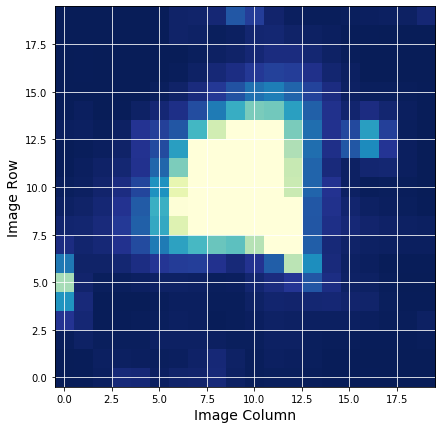

In [28]:
hdu1 = hdulist[0]
firstImage = hdu1[1].data['FLUX'][0]

fig = plt.figure(figsize=(7, 7))
plot_cutout(firstImage)
plt.xlabel('Image Column',fontsize = 14)
plt.ylabel('Image Row',fontsize = 14)


Show the first image of the second file


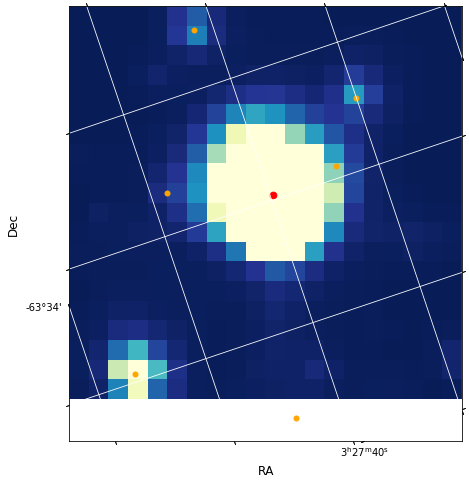

In [29]:
hdu2 = hdulist[1]

firstImage = hdu2[1].data['FLUX'][0]

wcs = WCS(hdu2[2].header)

fig = plt.figure(figsize = (8, 8))
fig.add_subplot(111, projection = wcs)
plot_cutout(firstImage)

plt.xlabel('RA', fontsize = 12)
plt.ylabel('Dec', fontsize = 12)


starloc = wcs.all_world2pix([[ra,dec]],0)  #Second is origin
plt.scatter(starloc[0,0], starloc[0,1],s = 45,color = 'red')

# Plot nearby stars as well, which we created using our Catalog call above.
nearbyLoc = wcs.all_world2pix(nearbyStars[1:],0)
plt.scatter(nearbyLoc[1:, 0], nearbyLoc[1:, 1], 
            s = 25, color = 'orange')

Create a Light Curve from the Cutout
Two functions created, to appply a photometric aperture to one image and to apply that to all the images in the FLUX array.

In [0]:
def aperture_phot(image, aperture):
    """
    Sum-up the pixels that are in the aperture for one image.
    image and aperture are 2D arrays that need to be the same size.
    
    aperture is a boolean array where True means to include the light of those pixels.
    """
    flux = np.sum(image[aperture])

    return flux

def make_lc(flux_data, aperture):
    """
    Apply the 2d aperture array to the and time series of 2D images. 
    Return the photometric series by summing over the pixels that are in the aperture.
    
    Aperture is a boolean array where True means it is in the desired aperture.
    """
    
    flux = np.array(list (map (lambda x: aperture_phot(x, aperture), flux_data) ) )

    return flux


Create a photometric time series using all the pixels in the image.


Text(0.5, 1.0, 'Flux in Photometric Aperture')

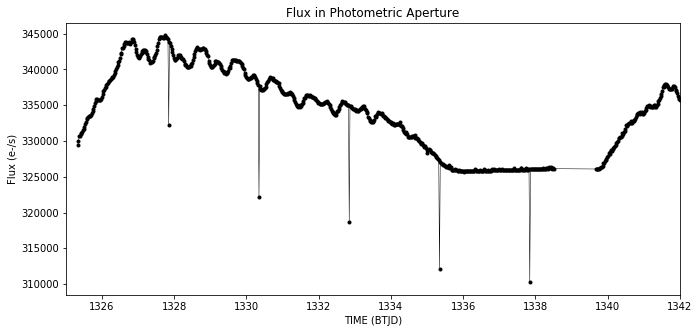

In [32]:
# Use all pixels in our aperture.
aperture = hdu1[2].data == 1

flux1 = make_lc(hdu1[1].data['FLUX'], aperture)
time1 = hdu1[1].data['TIME']

plt.figure(figsize = (11,5))
plt.plot(time1, flux1, 'k.-', lw = .5)
plt.xlim(1325,1342)
plt.xlabel('TIME (BTJD)')
plt.ylabel('Flux (e-/s)')
plt.title('Flux in Photometric Aperture')

Estimate the background

Text(0.5, 1.0, 'Background Flux')

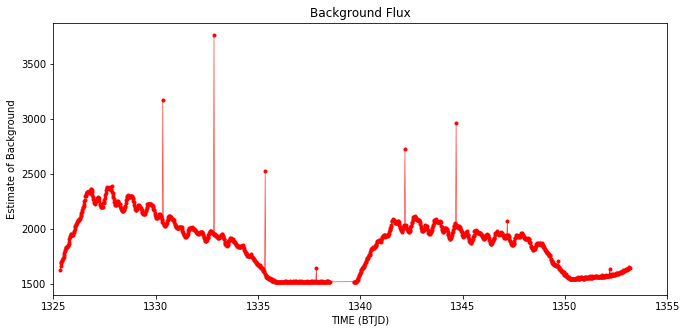

In [33]:
# Plot the flux change of the dimmest pixels by using percentile.
bkgAperture = hdu1[1].data['FLUX'][0] < np.percentile(hdu1[1].data['FLUX'][0], 5)

bkgFlux1 = make_lc(hdu1[1].data['FLUX'], bkgAperture)
time1 = hdu1[1].data['TIME']

plt.figure(figsize = (11, 5))
plt.plot(time1, bkgFlux1, 'r.-', lw = .5)

plt.xlim(1325, 1355)
plt.xlabel('TIME (BTJD)')
plt.ylabel('Estimate of Background')
plt.title('Background Flux')

Subtract the background from the flux time series

Text(0.5, 1.0, 'Background Subtracted Flux')

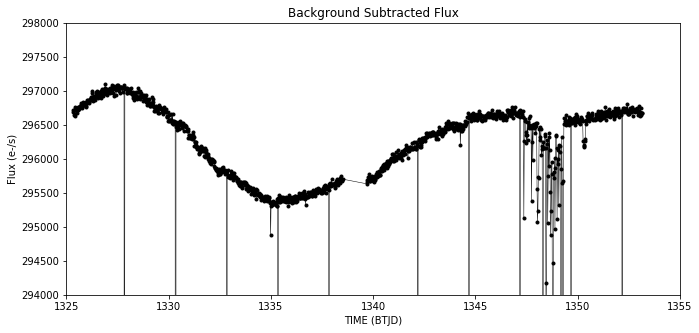

In [34]:
bkgSubFlux = flux1 - (bkgFlux1 * np.sum(aperture) / np.sum(bkgAperture) )

plt.figure(figsize = (11,5))
plt.plot(time1, bkgSubFlux,'.-k', lw = 0.5)

plt.ylim(294000, 298000)
plt.xlim(1325, 1355)
plt.xlabel('TIME (BTJD)')
plt.ylabel('Flux (e-/s)')
plt.title('Background Subtracted Flux')

Interpretation:

The data might indicate that we are dealing with a pulsating star. My first guess was an eclipsing binary, but evidently the orbit period is somewhat too long for an eclipsing binary, so probably it's a pulsating star. Nonetrheless, I cannot determine that with 100% certainty. The weird noise between 1345 and 1350 BTJD time is most likely due to technical issues - defocusing of camera at that time. Before this plot was generated, many other plots were formed for different stars, and the same kind of noise was observed in those too at the same time period. The noise is even clearly visible from the animation below (there too we got the same kind of defocusing of a camera for different stars at the same time).

# Generating a Video

Source of the improved, time-lapsed code: Programming God Felix

In [37]:
############### HELPER FUNCTIONS ################################
def json_to_table(fields, data):
    rx = re.compile(r"varchar\((\d+)\)")
    data_table = Table()
    for col, atype in [(x['colname'], x['datatype']) for x in fields]:
        col = col.strip()
        if "varchar" in atype:
            match = rx.search(atype)
            atype = "U" + match.group(1)
        if atype == "real":
            atype = "float"
        data_table[col] = np.array([x.get(col, None) for x in data], dtype=atype)
    return data_table

def find_index(cutout_table, btjd):
    return (np.abs(cutout_table['TIME'] - btjd)).argmin()

''' Creates animation based on image array'''
def make_animation(data_array, start_frame=0, end_frame=None, vmin=None, vmax=None, delay=1):    
    if not vmin:
        vmin = np.min(data_array)
    if not vmax:
        vmax = np.max(data_array)
        
    if not end_frame:
        end_frame = len(data_array) - 1 # set to the end of the array
    num_frames = end_frame - start_frame + 1 # include the end frame
        
    def animate(i, fig, ax, binarytab, start=0):
        """Function used to update the animation"""
        ax.set_title("Epoch #" + str(i+start))
        im = ax.imshow(binarytab[i+start], cmap=plt.cm.YlGnBu_r, vmin=vmin, vmax=vmax)
        return im,
    
    # Create initial plot.
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(data_array[start_frame], cmap=plt.cm.YlGnBu_r, vmin=vmin, vmax=vmax)

    ani = animation.FuncAnimation(fig, animate, fargs=(fig, ax, data_array, start_frame), frames=num_frames, 
                                  interval=delay, repeat_delay=1)
    plt.close()
    return ani

'''preprocessing of data to create the animation (also draws nice plots)'''
def animation_preprocessing(ticid):
  weird_tic_id = ticid
  exomast_url = "https://exo.mast.stsci.edu/api/v0.1/"
  list_tce_query = f"{exomast_url}dvdata/tess/{weird_tic_id}/tces/"
  tce_dict = requests.get(list_tce_query).json()
  weird_sector, weird_tce = tce_dict['TCE'][0].split(":")
  dv_metadata_query = f"{exomast_url}dvdata/tess/{weird_tic_id}/info/?tce={weird_tce}&sector={weird_sector}"
  metadata = requests.get(dv_metadata_query).json()
  dv_lightcurve_query = f"{exomast_url}dvdata/tess/{weird_tic_id}/table/?tce={weird_tce}&sector={weird_sector}"
  data_dict = requests.get(dv_lightcurve_query).json()
  weird_lightcurve = json_to_table(data_dict['fields'],data_dict['data'])
  ra = metadata['DV Data Header']['RA_OBJ']
  dec = metadata['DV Data Header']['DEC_OBJ']
  obj_coord = SkyCoord(ra,dec,unit="deg")
  Tesscut.get_sectors(obj_coord)
  cutout_hdu = Tesscut.get_cutouts(obj_coord, size=50)[0]
  cutout_table = cutout_hdu[1].data
  bfig = plotting.figure(plot_width=850, plot_height=250, title=f"Detrended Lightcurve (TIC{weird_tic_id})")
  bfig.circle(weird_lightcurve["TIME"],weird_lightcurve["LC_DETREND"], fill_color="black",size=1, line_color=None)
  plotting.show(bfig)
  return cutout_table['FLUX']

'''Creates an animation showing what the observed object looks like based on the ticid and a
timelapse factor that determines how sped up the video is''' 
def create_animation(ticid, timelapse_factor):
  # preprocess the data
  cutout_flux = animation_preprocessing(ticid=ticid)
  # (get every tenth frame)
  cutout_flux_timelapse = []
  for i in range(len(cutout_flux)):
    if (i%timelapse_factor) == 0:
      cutout_flux_timelapse.append(cutout_flux[i])
  print("Timelapse Frames:", len(cutout_flux_timelapse))
  start = 0
  end = len(cutout_flux_timelapse)-1
  # create actual animation
  make_animation(cutout_flux_timelapse, start, end, vmax=500)
  return cutout_flux_timelapse, start, end

cutout_flux_timelapse, start, end = create_animation(279741379,10)
make_animation(cutout_flux_timelapse, start, end)

Timelapse Frames: 129


In the timelapse a defocus is seen around the Epoch #109. Felix and I looked into it and we figured that no matter which star we chose, the same defocusing happened at this epoch, which suggest that the reason for it is defocusing of the camera, and not an interesting phenomena with a physical meaning. No change in flux can be explicity seen from the timelapse, as the change in luminosity is not big enough. 

# PART 3: Light curve of a supernova

With the aim of presenting the reader with different kinds of light curves (due to different phenomena), a light curve for a short supernova explosion (FELT) was generated. The important points will be commented below.

In [38]:
tpf = search_targetpixelfile(212593538, campaign=6).download()
tpf.shape

(3545, 8, 8)

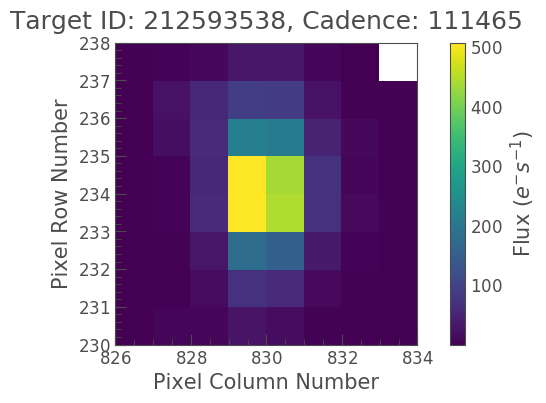

In [39]:
tpf.plot(frame=100);

In [40]:
postage_stamp_mask = tpf.hdu[2].data > 0
postage_stamp_mask.sum()

63

In [0]:
lc_raw = tpf.to_lightcurve(aperture_mask='all')
_, spurious_cadences = lc_raw.flatten().remove_outliers(return_mask=True)
lc_clean = lc_raw[~spurious_cadences]

In [0]:
lc_raw = tpf.to_lightcurve(aperture_mask='all')
_, spurious_cadences = lc_raw.flatten().remove_outliers(return_mask=True)
lc_clean = lc_raw[~spurious_cadences]

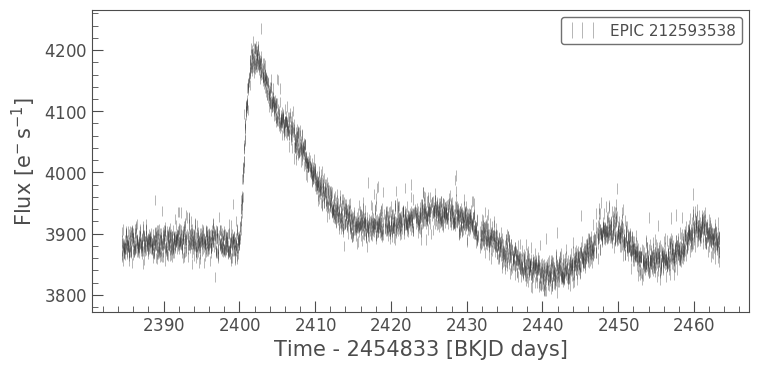

In [43]:
lc_clean.errorbar(alpha=0.5, normalize=False);

Noise will be removed:

In [0]:
aperture_mask = postage_stamp_mask.copy()
aperture_mask[:,-1] = False
aperture_mask[:,0] = False
background_mask = ~aperture_mask & postage_stamp_mask

In [45]:
N_targ_pixels, N_back_pixels = aperture_mask.sum(), background_mask.sum()
N_targ_pixels, N_back_pixels

(48, 15)

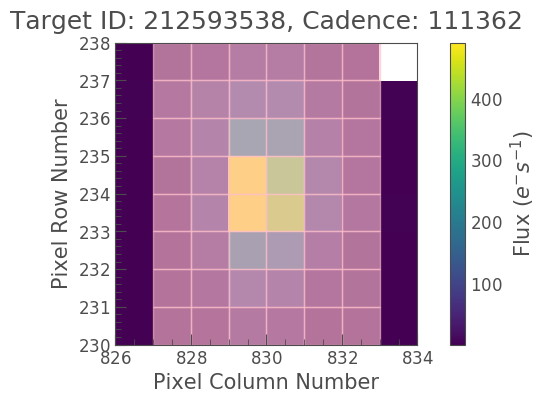

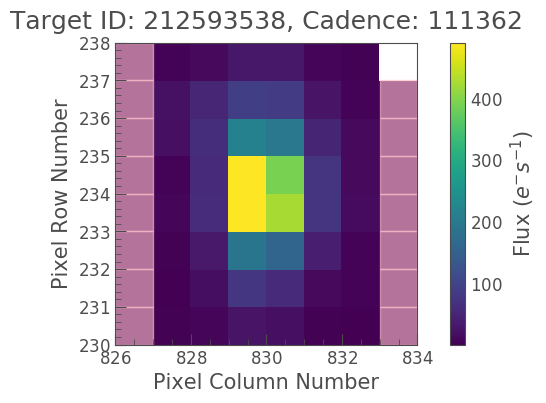

In [46]:
tpf.plot(aperture_mask=aperture_mask);
tpf.plot(aperture_mask=background_mask);

In [0]:
lc_aper = tpf.to_lightcurve(aperture_mask=aperture_mask) 
lc_back_per_pixel = tpf.to_lightcurve(aperture_mask=background_mask) / N_back_pixels

In [0]:
lc_net = lc_aper - lc_back_per_pixel.flux * N_targ_pixels

In [0]:
lc_net = lc_net[~spurious_cadences]

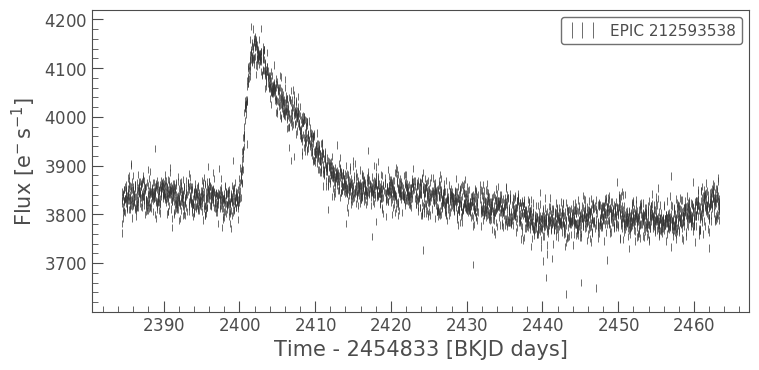

In [50]:
lc_net.errorbar();

This light curve significantly differs from other light curves presented above. Here the flux gets increased, which makes perfect sense as we are observing a supernova explosion (brightest events in the universe). The even at hand last several days, though usually supernovas can last much longer. These special kinds of supernova events are called Fast-Evolving Luminous Transients (FELTs). 

DISCLAIMER: sometimes the code doesn't want to connect to the database so the code doesn't run... Which is a characteristics of the database, not of my code.